In [77]:
import sys
import datetime
import pandas as pd
import numpy as np
import datetime as dt
import time
import math
from pandas.tseries.offsets import DateOffset
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import plotly.graph_objects as go
from scipy.signal import argrelextrema
from scipy.stats import linregress
#import autosklearn

import warnings
warnings.filterwarnings("ignore")
locx = 'S:/Matrix/IA/IADE/0_Personal/1_Antonio/risk_return_contribution/pricing/files/'

def get_freq(data, datecol='t', freq='5min'):
    data = data.set_index(pd.DatetimeIndex(data[datecol]))
    data.index.name = None
    df = pd.DataFrame()
    df['o'] = data.o.resample(freq).first()
    df['h'] = data.h.resample(freq).max()
    df['l'] = data.l.resample(freq).min()
    df['c'] = data.c.resample(freq).last()
    df['v'] = data.v.resample(freq).sum()
    return df.reset_index().rename(columns={'index':datecol})

def rets_to_ts(df1, basedate, baseval=100, datecol='', dropfirstrow=False):
    '''calculates time series based on returns (format: output file from calc_rets_pf)
    inputs: df1 - dataframe in format calc_rets_pf()
            datecolum: if parameter not empty list, then will use that as index for the date
    output: dataframe with time series added to h_ column; base date and value are added
    '''
    basedate = pd.to_datetime(basedate, format='%Y-%m-%d', dayfirst=True)
    if dropfirstrow:
        df1 = df1.tail(len(df1) - 1)

    if len(datecol) > 0:
        df1.set_index(datecol, inplace=True)
        df1.index.name = None

    df1 = pd.concat([pd.DataFrame(index=[basedate], columns=list(df1.columns)), df1], axis=0)
    df1 = df1.fillna(0)

    basevals = [baseval for i in df1.columns]
    vals = []

    for i in range(0, len(df1)):
        val = basevals * (1 + df1.iloc[i, :])
        vals.append(val)
        basevals = val

    df1.loc[:, df1.columns] = vals

    return df1

def calc_bt_compare(test, dtcol='Date', retcol='tr',basedate='', baseval=100, trdcol='trd',pfname='pf', tfe=0.001):
    if basedate=='':
        basedate = str(list(test[dtcol])[0])[:10]
    ts = rets_to_ts(test[[dtcol,retcol]], basedate=basedate, baseval=baseval, datecol=dtcol, dropfirstrow=False).rename(columns={retcol:'bm'})
    ts1 = rets_to_ts(calc_trd_ret(test[[dtcol,retcol,trdcol]], fldretout=pfname, tfe=tfe)[[dtcol,pfname]], basedate=basedate, baseval=100, datecol=dtcol, dropfirstrow=False)

    p = pd.concat([ts1, ts], axis=1)
    p.plot()
    p[pfname+'-bm'] = p[pfname] - p['bm']
    p[pfname+'-0'] = p[pfname] - 100
    p[[pfname+'-bm',pfname+'-0']].plot()
    
    return p

def timeit(t1, msg=''):
    t2 = dt.datetime.now()
    t = (t2 - t1).seconds
    if t/60 >= 1:
        print(msg, "runtime:", str(int(t / 60)) + " min" , str(t % 60) + " sec")
    else:
        print(msg, "runtime:", str(t) + " sec")

In [ ]:
## create BU5m.txt file
#locx = 'S:/Matrix/IA/IADE/0_Personal/1_Antonio/risk_return_contribution/pricing/files/'
#data = pd.DataFrame()
#for i in range(1,6): #full (1,6)
#    data_ = pd.read_csv(locx + 'BU1m'+str(i)+'.txt')
#    data = pd.concat([data, data_])
#data = data.reset_index(drop=True)
#data.columns = ['t','o','h','l','c','v']
#data['t'] = data['t'].map(lambda x: datetime.datetime.fromtimestamp(x))
#del data['t']
#get_freq(data).to_csv(locx + 'BU5m.txt')

In [3]:
## get pricing, convert to different frequencies
df5 = pd.read_csv(locx + 'BU5m.txt')
df15 = get_freq(df5, freq='15min')
df1h = get_freq(df15, freq='1h')
df1d = get_freq(df1h, freq='1d')

In [129]:
## trying with different freqs:
#df = df1h.copy()
#df = df1d.copy()
#df = df5.copy()
df = df15.copy()

df['sign'] = np.where(df['o']<df['c'], 'pos', np.where(df['o']>df['c'], 'neg', 'eq')) # freq sign
df['iret'] = (df['c']-df['o']) / df['o'] # intraperiod return
df['constct'] = df['sign'].groupby((df['sign'] != df['sign'].shift()).cumsum()).cumcount() + 1 # count consecutive signs
df['nextsame'] = df['constct'] < df['constct'].shift(-1)
df['nextiret'] = df['iret'].shift(-1)
df['shortloss'] = -(df['h']-df['o']) / df['o']
df['longloss'] = (df['l']-df['o']) / df['o']
df.tail(3)

,t,o,h,l,c,v,sign,iret,constct,nextsame,nextiret,shortloss,longloss
146341,2021-10-19 15:15:00,62396.99,62721.29,62227.26,62539.71,1154.692970,pos,0.002287,2,True,0.002418,-0.005197,-0.002720
146342,2021-10-19 15:30:00,62539.72,63278.61,62243.48,62690.92,3079.024756,pos,0.002418,3,True,0.001683,-0.011815,-0.004737
146343,2021-10-19 15:45:00,62701.00,63120.00,62579.00,62806.52,1348.758960,pos,0.001683,4,False,NaN,-0.006683,-0.001946


In [93]:
#dangerous periods, need to check for leveraged positions

#df[df.shortloss.isin(list(df.shortloss.sort_values().head(10)))]
#df[df.longloss.isin(list(df.longloss.sort_values().head(10)))]

In [97]:
consct = 2
print(df[df.sign!='eq'][(df.constct==consct)].groupby(['sign','nextsame']).count()['t'] / df[df.sign!='eq'][(df.constct==consct)].groupby(['sign']).count()['t'])
print('')
df[(df.constct==consct) & (df.sign=='pos')].nextiret.sum(), df[(df.constct==consct) & (df.sign=='neg')].nextiret.sum()

sign  nextsame
neg   False       0.550260
      True        0.449740
pos   False       0.541647
      True        0.458353
Name: t, dtype: float64



(-0.7695551053849784, 0.47714824844578496)

In [130]:
#Robotonto 1.0 - strategy returns

df.loc[(df.constct==3) & (df.sign=='neg'), 'long3'] = df.loc[(df.constct==3) & (df.sign=='neg'), 'nextiret']
df['long3'].fillna(0, inplace=True)
df.loc[(df.constct==3) & (df.sign=='pos'), 'short3'] = -df.loc[(df.constct==3) & (df.sign=='pos'), 'nextiret']
df['short3'].fillna(0, inplace=True)

df.loc[(df.constct==3) & (df.sign=='neg'), 'longshort3'] = df.loc[(df.constct==3) & (df.sign=='neg'), 'nextiret']
df.loc[(df.constct==3) & (df.sign=='pos'), 'longshort3'] = -df.loc[(df.constct==3) & (df.sign=='pos'), 'nextiret']
df['longshort3'].fillna(0, inplace=True)

df.loc[(df.constct==2) & (df.sign=='neg'), 'long2'] = df.loc[(df.constct==2) & (df.sign=='neg'), 'nextiret']
df['long2'].fillna(0, inplace=True)
df.loc[(df.constct==2) & (df.sign=='pos'), 'short2'] = -df.loc[(df.constct==2) & (df.sign=='pos'), 'nextiret']
df['short2'].fillna(0, inplace=True)

df.loc[(df.constct==2) & (df.sign=='neg'), 'longshort2'] = df.loc[(df.constct==2) & (df.sign=='neg'), 'nextiret']
df.loc[(df.constct==2) & (df.sign=='pos'), 'longshort2'] = -df.loc[(df.constct==2) & (df.sign=='pos'), 'nextiret']
df['longshort2'].fillna(0, inplace=True)

In [133]:
df = df.tail(5000).copy().reset_index(drop=True) ## slice it for testing

#calc portfolios
retcols = ['iret','long3', 'short3', 'longshort3', 'long2', 'short2','longshort2']
basedate = df.t[0]

t1 = dt.datetime.now()

dfres = pd.DataFrame()
for retcol in retcols:
    dfres = pd.concat([dfres,rets_to_ts(df[['t',retcol]], basedate, baseval=100, datecol='t', dropfirstrow=False)], axis=1)

timeit(t1, msg='done!')

done! runtime: 18 sec


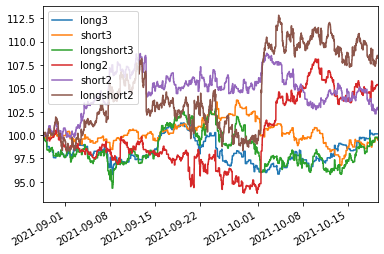

In [134]:
dfres.iloc[:,1:].plot()

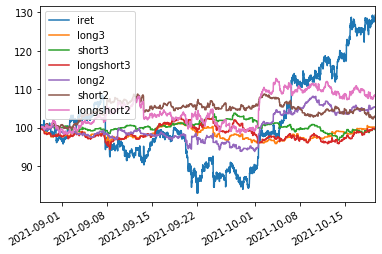

In [135]:
dfres.iloc[:,:].plot() #including underlying

In [ ]:
#TO DO

# try not countring small returns as neg or pos
# try staying invested for 2 periods, not just 1
# try alternating long short depending on the short term trend: on uptrend only long